In [1]:
import os
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
#from google.colab.patches import cv2_imshow
from PIL import Image
import cv2
import scipy.misc
import matplotlib
#import xgboost as XGBClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, ConvLSTM2D, Flatten, Dropout, MaxPooling2D,MaxPooling3D, TimeDistributed, Conv2D, LSTM, SimpleRNN, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import MinMaxScaler

import io
import matplotlib.pyplot as plt
import imageio
from sklearn.metrics import r2_score
# from IPython.display import Image, display
# from ipywidgets import widgets, Layout, HBox
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import UpSampling3D
from tensorflow.keras.layers import MaxPooling3D
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import History
from tensorflow import keras
import tensorflow_addons as tfa

from keras.layers import Conv3D, MaxPool3D, Flatten, Dense, LSTM
from keras.layers import Dropout, Input, BatchNormalization
from sklearn.metrics import confusion_matrix, accuracy_score
from plotly.offline import iplot, init_notebook_mode
from keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adadelta
import plotly.graph_objs as go
from matplotlib.pyplot import cm
from keras.models import Model
import numpy as np
import keras
import h5py
import tensorflow as tf


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.11.0 and is not supported. 
Some things might work, some things might not.
If you were to enco

In [2]:
def load_data():
    data = []
    path = rf"{os.getcwd()}\src\yearly_data"
    for file in os.listdir(path):
        df = pd.read_csv(f'{path}/{file}')
        df.drop(columns=[df.columns[0]], axis=1, inplace=True)
        df.fillna(0.0, inplace=True)
        data.append(df.to_numpy())
    return np.array(data)

data = load_data()


In [3]:
full_data = data
full_data.shape

(40, 277, 228)

In [4]:
data = full_data

In [5]:
data_shifted = data[2:]
data_shifted.shape

(38, 277, 228)

In [6]:
data = data[:-2]
data.shape

(38, 277, 228)

In [7]:
data.shape

(38, 277, 228)

In [27]:
data = data.reshape((38, 277, 228, 1))
# data = data.reshape((2100, 277, 228, 1))

In [28]:
data.shape

(38, 277, 228, 1)

In [29]:
data[0][0][0]

array([49.02999878])

In [30]:
train_dataset = data[:32]
train_labels = data_shifted[:32]
test_dataset = data[-6:]
test_labels = data_shifted[-6:]
# train_dataset = data[:1700]
# train_labels = data_shifted[:1700]
# test_dataset = data[-400:]
# test_labels = data_shifted[-400:]
print("Training Dataset Shapes: " + str(train_dataset.shape) + ", " + str(train_labels.shape))
print("Validation Dataset Shapes: " + str(test_dataset.shape) + ", " + str(test_labels.shape))

Training Dataset Shapes: (32, 277, 228, 1), (32, 277, 228)
Validation Dataset Shapes: (6, 277, 228, 1), (6, 277, 228)


In [12]:
# dataset = [data[0], data[1]]
# dataset_test = load_real_samples('F:\Jyoti Shukla -MS\karnataka dataset\paired_padded_arrays_test_total_AVHRR_data.npz')
# train_dataset, train_labels = dataset[0],dataset[1]
# test_dataset, test_labels = dataset_test[0], dataset_test[1]
# # Inspect the dataset.
# print("Training Dataset Shapes: " + str(train_dataset.shape) + ", " + str(train_labels.shape))
# print("Validation Dataset Shapes: " + str(test_dataset.shape) + ", " + str(test_labels.shape))

In [32]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
    # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[i+1:end_ix+1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y), n_steps

In [33]:
x_train, y_train, n_steps = split_sequence(train_dataset, 4)
x_test, y_test, n_steps = split_sequence(test_dataset,4)
print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_test.shape) + ", " + str(y_test.shape))

Training Dataset Shapes: (28, 4, 277, 228, 1), (28, 4, 277, 228, 1)
Validation Dataset Shapes: (2, 4, 277, 228, 1), (2, 4, 277, 228, 1)


In [58]:
seq = keras.Sequential(
    [
        keras.Input(shape = (None, *x_train.shape[2:])),
        layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(filters=1, kernel_size=(3,3), activation='relu', padding='same')
    ]
)

seq.compile(loss='mse', optimizer='adam')
seq.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, None, 277, 228, 1  160       
                             6)                                  
                                                                 
 batch_normalization_41 (Bat  (None, None, 277, 228, 1  64       
 chNormalization)            6)                                  
                                                                 
 conv2d_14 (Conv2D)          (None, None, 277, 228, 1  2320      
                             6)                                  
                                                                 
 batch_normalization_42 (Bat  (None, None, 277, 228, 1  64       
 chNormalization)            6)                                  
                                                                 
 conv2d_15 (Conv2D)          (None, None, 277, 228, 1 

In [243]:
len(train_dataset)

32

In [59]:
seq.fit(
    x_train,
    y_train,
    batch_size=1,
    epochs=10,
    validation_split=0.1
)

Epoch 1/10


25/25 [==============================] - 12s 425ms/step - loss: 2288.3674 - val_loss: 2798.8025
Epoch 2/10
25/25 [==============================] - 10s 408ms/step - loss: 2059.6833 - val_loss: 3028.0618
Epoch 3/10
25/25 [==============================] - 10s 407ms/step - loss: 1875.0808 - val_loss: 2661.6907
Epoch 4/10
25/25 [==============================] - 10s 417ms/step - loss: 1701.1522 - val_loss: 1330.3680
Epoch 5/10
25/25 [==============================] - 11s 432ms/step - loss: 1546.2759 - val_loss: 1092.4323
Epoch 6/10
25/25 [==============================] - 10s 413ms/step - loss: 1403.9655 - val_loss: 1205.0693
Epoch 7/10
25/25 [==============================] - 10s 405ms/step - loss: 1281.9667 - val_loss: 853.1861
Epoch 8/10
25/25 [==============================] - 10s 410ms/step - loss: 1167.4100 - val_loss: 642.1469
Epoch 9/10
25/25 [==============================] - 10s 404ms/step - loss: 1067.0283 - val_loss: 652.2414
Epoch 10/10
25/25 [==============================] 

In [60]:
pred = seq.predict(x_test)

1/1 [==============================] - 0s 337ms/step


<AxesSubplot: >

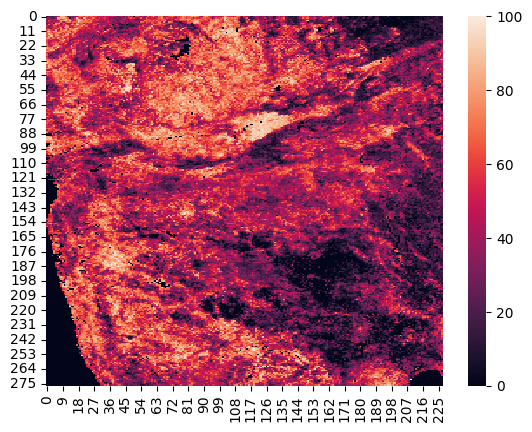

In [52]:
sns.heatmap(y_test[0][0].reshape((277, 228)))

<AxesSubplot: >

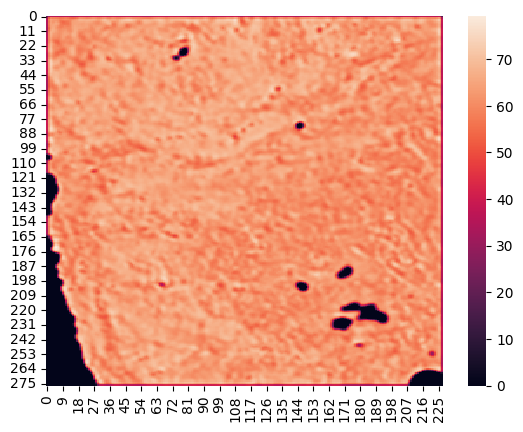

In [61]:
sns.heatmap(pred[0][0].reshape((277, 228)))

<AxesSubplot: >

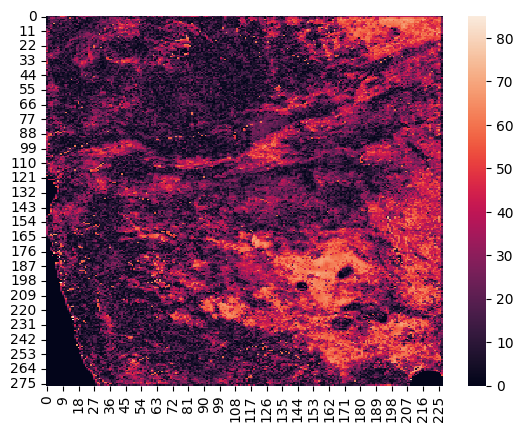

In [62]:
error = abs(pred[0][0].reshape((277, 228)) - y_test[0][0].reshape((277, 228)))
sns.heatmap(error)

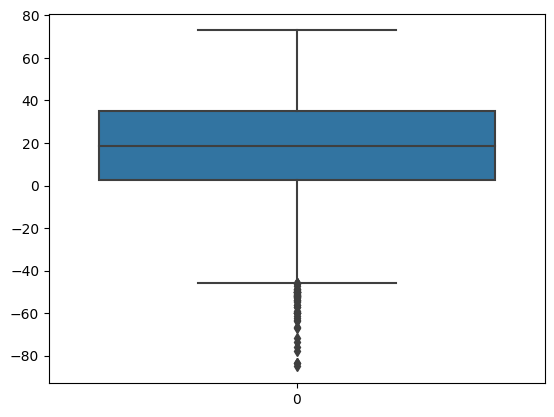

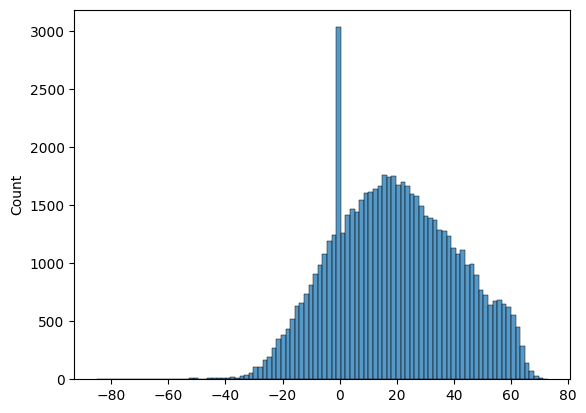

In [63]:
error = pred[0][0].reshape((277, 228)) - y_test[0][0].reshape((277, 228))
error = error.reshape((277*228))
sns.boxplot(error)
plt.show()
sns.histplot(error)
plt.show()

In [268]:
import pickle

pickle.dump(seq, open(rf"{os.getcwd()}/models/convlstm2d.pkl", "wb"))


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\batch_normalization
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_1
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_2
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_3
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_4
......vars
.........0
.........1
.........2
.........3
...layers\conv3d
......vars
.........0
.........1
...layers\conv_lstm2d
......vars
...layers\conv_lstm2d\cell
......vars
.........0
.........1
.........2
...layers\conv_lstm2d_1
......vars
...layers\conv_lstm2d_1\cell
......vars
.........0
.........1
.........2
...layers\conv_lstm2d_2
......vars
...layers\conv_lstm2d_2\cell
......vars
.........0
.........1
.........2
...layers\conv_lstm2d_3
......vars
...layers\conv_lstm2d_3\cell
......vars
.........0
.........1
.........2
...layers\conv_lstm2d_4